In [54]:
import importlib
import os
import argparse
import time

from torchvision import datasets
from torchvision import transforms
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import datasets as ds
import models
import utils
from PoseExtraction import PoseNormalization
# from multiPoseExtraction import MultiPoseExtraction

import matplotlib.pyplot as plt
import glob
import imageio
import matplotlib.patches as patches
import cv2
import numpy as np 

class Noise(nn.Module):
    def __init__(self, scale=0.01):
        super(Noise, self).__init__()
        self.scale = scale

    def forward(self, x):
        device = x.device
        noise = (torch.randn_like(x)*self.scale).to(device)
        return x + noise

def plot_arrow_img(ax, means, orientations, img_shape, arrow_scale=2, color='r'):
    mean_x = means[0, 0, 0].cpu().data.numpy()
    mean_y = means[0, 1, 0].cpu().data.numpy()

    rot = orientations[0].cpu().data.numpy()
    arrow_start = (mean_x, img_shape[1] - mean_y)
    arrow_end = (rot[0, 0]*arrow_scale, -1*rot[0, 1]*arrow_scale)

    #         ax[index % row_length].arrow(arrow_start[0], arrow_start[1], arrow_end[0], arrow_end[1], 
    #                     head_width=0.5, head_length=1, fc='red', ec='r', linewidth=4, alpha=1)

    ax.arrow(arrow_start[0], arrow_start[1], arrow_end[0], arrow_end[1], 
                head_width=1.5, head_length=1, fc='red', ec=color, linewidth=4, alpha=0.8)


In [2]:
train_loader, test_loader, dataset_details = ds.AffNIST()

torch.Size([5000, 1, 28, 28])
torch.Size([5000, 1])


In [56]:

for batch_index in range(12):
    for i, (img_batch, label) in enumerate(train_loader):
        if i == batch_index:
            break


    for img_index in range(30):
        img = img_batch[img_index:img_index+1]
        features = cnn.layer1(img.cuda())
        features = Noise(scale=0.0001)(features)
        pose_norm = PoseNormalization(1, (28, 28)).to(device)
        new_img, mu_W, orientations, confidence, theta, (L1, L2) = pose_norm(img.cuda())
        orientation = theta[:, :, 0].unsqueeze(0)
        # new_img = apply_theta_transform(img, theta)

        row_length = 4
        fig, ax = plt.subplots(2, 1)
        ax[0].imshow(utils.tensor_to_numpy_img(img), cmap='gray')


        plot_arrow_img(ax[0], mu_W, orientations, 
                           (28, 28), 5, 'r')



        # print(new_img.shape)
        ax[1].imshow(utils.tensor_to_numpy_img(new_img), cmap='gray')
        ax[0].axis('off')
        ax[1].axis('off')
        plt.savefig('./AffNISTResults/fig_{}'.format(batch_index*30 + img_index))
        plt.close()

In [9]:
class PINN(torch.nn.Module):
    def __init__(self, channel_num, img_shape, num_classes=10):
        super(PINN, self).__init__()        
        self.pose_norm = PoseNormalization(16, (14, 14))

        self.layer1 = nn.Sequential(
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(channel_num, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        
        self.fc = nn.Linear(int(img_shape[1]/4)*int(img_shape[0]/4)*32, num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        
        
        _, mu_W, orientations, confidence, theta, (L1, L2) = self.pose_norm(x)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        x = self.layer2(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # x = torch.cat([x, orientations[:, :, 0]], dim=1)
        # x = self.fc2(x)

        return x


In [10]:
class CNN(torch.nn.Module):
    def __init__(self, channel_num, img_shape):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(channel_num, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ReflectionPad2d((1, 1, 1, 1)),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            Noise()
        )
        
        
#         self.fc = nn.Linear(int(img_shape[1]/4)*int(img_shape[0]/4)*32, 10)
        self.fc2 = nn.Sequential(nn.Linear(7*7*32, 20),
                                 nn.Linear(20, 10))
        
    def forward(self, x):
        x = self.layer1(x)
        x = x.view(-1, 7*7*32)
        x = self.fc2(x)

        return x


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size, channel_num, height, width = dataset_details

cnn_basic = CNN(channel_num=channel_num, img_shape=[height, width]).to(device)
criterion_cnn_basic = nn.CrossEntropyLoss()

cnn = PINN(channel_num=channel_num, img_shape=[height, width]).to(device)
criterion_cnn = nn.CrossEntropyLoss()

In [13]:
learning_rate = 0.0005 * 2
batch_num = 10
epoch_num = 10
# optimizer_pinn = torch.optim.Adam([param for param in pinn.parameters() if param.requires_grad], 
#                                   lr=learning_rate)
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
optimizer_cnn_basic = torch.optim.Adam(cnn_basic.parameters(), lr=learning_rate)
# cnn_basic, cnn_basic_loss, cnn_basic_acc = utils.train_net(cnn_basic, train_loader, 
#                                                            test_loader, 
#                                                            criterion_cnn_basic, 
#                                                            optimizer_cnn_basic, batch_num, epoch_num)
cnn, cnn_loss, cnn_acc, cnn_val_acc = utils.train_net(cnn, train_loader, test_loader, criterion_cnn, optimizer_cnn, batch_num, epoch_num)

TOTAL TRAIN 640
TOTAL VALIDATION 11000
TOTAL TEST 5000
STOPPING EPOCH
Loss: 0.005968732805922627, Acc: 0.90625, Validation Loss: 0.006461238332770088
STOPPING EPOCH
Loss: 0.005559278605505824, Acc: 0.8984375, Validation Loss: 0.005578066189180721
STOPPING EPOCH
Loss: 0.0052946629002690315, Acc: 0.9, Validation Loss: 0.005417502731084824
STOPPING EPOCH
Loss: 0.0045438937842845915, Acc: 0.925, Validation Loss: 0.005176926998929544
STOPPING EPOCH
Loss: 0.004327024635858834, Acc: 0.915625, Validation Loss: 0.004592152014374733
STOPPING EPOCH
Loss: 0.004153146944008768, Acc: 0.9171875, Validation Loss: 0.005522847552191127
STOPPING EPOCH
Loss: 0.004434007429517805, Acc: 0.909375, Validation Loss: 0.004602416230873628
STOPPING EPOCH
Loss: 0.004078633664175868, Acc: 0.925, Validation Loss: 0.0039353083778511395
STOPPING EPOCH
Loss: 0.003632132790517062, Acc: 0.9328125, Validation Loss: 0.003572870840403167
STOPPING EPOCH
Loss: 0.003522759675979614, Acc: 0.9421875, Validation Loss: 0.003384200

In [12]:
for (img_batch, label_batch) in train_loader:
    break

AttributeError: 'PINN' object has no attribute 'multi_pose'

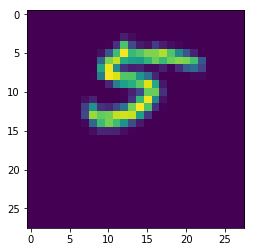

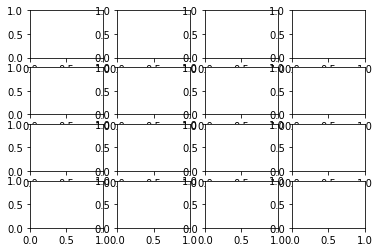

In [13]:
img_index = 9
img = img_batch[img_index:img_index+1]

features = cnn.layer1(img.cuda())
features.shape

row_length = 4
fig, ax = plt.subplots()
ax.imshow(utils.tensor_to_numpy_img(img))
fig2, ax2 = plt.subplots(4, 4)
means, orientations, (L1, L2) = cnn.multi_pose(features)
print(features.shape)
print(means.shape)
print(orientations.shape)

for index, activation_map in enumerate(features[0]):
    current_ax = ax2[index % 4, index // 4]
    current_ax.imshow(utils.tensor_to_numpy_img(activation_map))
    plot_arrow_img(current_ax, means[:, index], orientations[:, index], 
                   (14, 14), 2, 'y')
    
